This is a mini-project using naive Bayes for defect classification.


In [1]:
# Here we assume feature independence, continous features being normally distributed, discrete features having multinomial distributions, and all features are equally important.
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline


In [2]:
# Load dataset as df
df = pd.read_csv("/Users/E1012131/Downloads/Industrial_fault_detection.csv") 
df = df.dropna()  # Drop rows with missing values
NaN = ['FFT_Temp_0', 'FFT_Vib_0', 'FFT_Pres_0', 'FFT_Temp_1',
       'FFT_Vib_1', 'FFT_Pres_1', 'FFT_Temp_2', 'FFT_Vib_2', 'FFT_Pres_2',
       'FFT_Temp_3', 'FFT_Vib_3', 'FFT_Pres_3', 'FFT_Temp_4', 'FFT_Vib_4',
       'FFT_Pres_4', 'FFT_Temp_5', 'FFT_Vib_5', 'FFT_Pres_5', 'FFT_Temp_6',
       'FFT_Vib_6', 'FFT_Pres_6', 'FFT_Temp_7', 'FFT_Vib_7', 'FFT_Pres_7',
       'FFT_Temp_8', 'FFT_Vib_8', 'FFT_Pres_8', 'FFT_Temp_9', 'FFT_Vib_9',
       'FFT_Pres_9']
df = df_filtered = df[(df[NaN] != 0).any(axis=1)]
print(df.info())
columns = df.columns
print(columns)

<class 'pandas.core.frame.DataFrame'>
Index: 990 entries, 0 to 989
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  990 non-null    float64
 1   Vibration    990 non-null    float64
 2   Pressure     990 non-null    float64
 3   Flow_Rate    990 non-null    float64
 4   Current      990 non-null    float64
 5   Voltage      990 non-null    float64
 6   FFT_Temp_0   990 non-null    float64
 7   FFT_Vib_0    990 non-null    float64
 8   FFT_Pres_0   990 non-null    float64
 9   FFT_Temp_1   990 non-null    float64
 10  FFT_Vib_1    990 non-null    float64
 11  FFT_Pres_1   990 non-null    float64
 12  FFT_Temp_2   990 non-null    float64
 13  FFT_Vib_2    990 non-null    float64
 14  FFT_Pres_2   990 non-null    float64
 15  FFT_Temp_3   990 non-null    float64
 16  FFT_Vib_3    990 non-null    float64
 17  FFT_Pres_3   990 non-null    float64
 18  FFT_Temp_4   990 non-null    float64
 19  FFT_Vib_4    

In [3]:
# Split dataset into features and target variable
data = pd.DataFrame(df, columns=columns[:-1])  # All columns except the last one
target = pd.DataFrame(df, columns=[columns[-1]])  # Only the last column
print(data.head())
print(target.head())

   Temperature  Vibration   Pressure  Flow_Rate    Current     Voltage  \
0    46.006138   2.038362  56.775766   6.184385  12.409519  215.762403   
1    62.529168   2.573668  76.159843   8.279230  14.906390  215.465859   
2    77.295015   3.243491  92.372614   9.172789  15.054051  202.043568   
3    76.564164   3.142904  94.149558  13.775375  16.417891  216.699098   
4    78.281641   3.139960  94.441006  11.113106  10.899425  227.328291   

   FFT_Temp_0  FFT_Vib_0  FFT_Pres_0  FFT_Temp_1  ...  FFT_Pres_6  FFT_Temp_7  \
0  772.403056  32.436537  971.805333    3.760640  ...   23.428558   22.088538   
1  767.602396  32.395556  962.481517    8.365137  ...   25.072174   19.490310   
2  765.965069  32.032039  956.299456    9.559769  ...   20.179106   21.108993   
3  763.936438  33.039854  956.532232   10.251866  ...   19.947964   20.863726   
4  746.754887  33.018729  950.212816   18.313107  ...   14.754875    8.163300   

   FFT_Vib_7  FFT_Pres_7  FFT_Temp_8  FFT_Vib_8  FFT_Pres_8  FFT_Tem

In [4]:
X = data  # Features
y = target  # Target variable

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Here Dimensionailty reduction is done to increase accuracy of the model. Additionally, Grid search is used to find the optimum value of PCA components for highest accuracy

In [5]:
""" 
def make_undersampled_sets(X_train, y_train, n_sets=5):
    sets = []
    for rs in range(n_sets):
        rus = RandomUnderSampler(random_state=rs)
        X_res, y_res = rus.fit_resample(X_train, y_train)
        print(f"Set {rs} distribution:", Counter(y_res))
        sets.append((X_res, y_res))
    return sets

undersampled_sets = make_undersampled_sets(X_train, y_train, n_sets=10)

pipe = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),   # handle NaNs
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=10)),# PCA benefits from scaling
    ("pca", PCA(random_state=42, n_components=20)),
    #("smote", SMOTE(random_state=42)),
    ("nb", GaussianNB()),
])

param_grid = {
    "select__k": [2, 5, 8, 12, 16, "all"],
    "pca__n_components": [0.99, 0.95, 0.90, 0.85],
}

models = []
for i, (Xr, yr) in enumerate(undersampled_sets):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42 + i)  # vary seed slightly
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1,
        refit=True
    )
    grid.fit(Xr, yr)
    models.append(grid.best_estimator_)
    print(f"[Set {i}] best params:", grid.best_params_)

# Ensemble: average predicted probabilities if available
def gnb(models, X):
    # GaussianNB supports predict_proba
    probs = [m.predict_proba(X) for m in models]
    mean_probs = np.mean(probs, axis=0)
    return mean_probs

#gnb = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring="f1_macro", n_jobs=-1, refit=True, error_score='raise')
#gnb.fit(X_train, y_train.values.ravel())



#gnb = gnb.best_estimator_ """
gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())

GaussianNB()

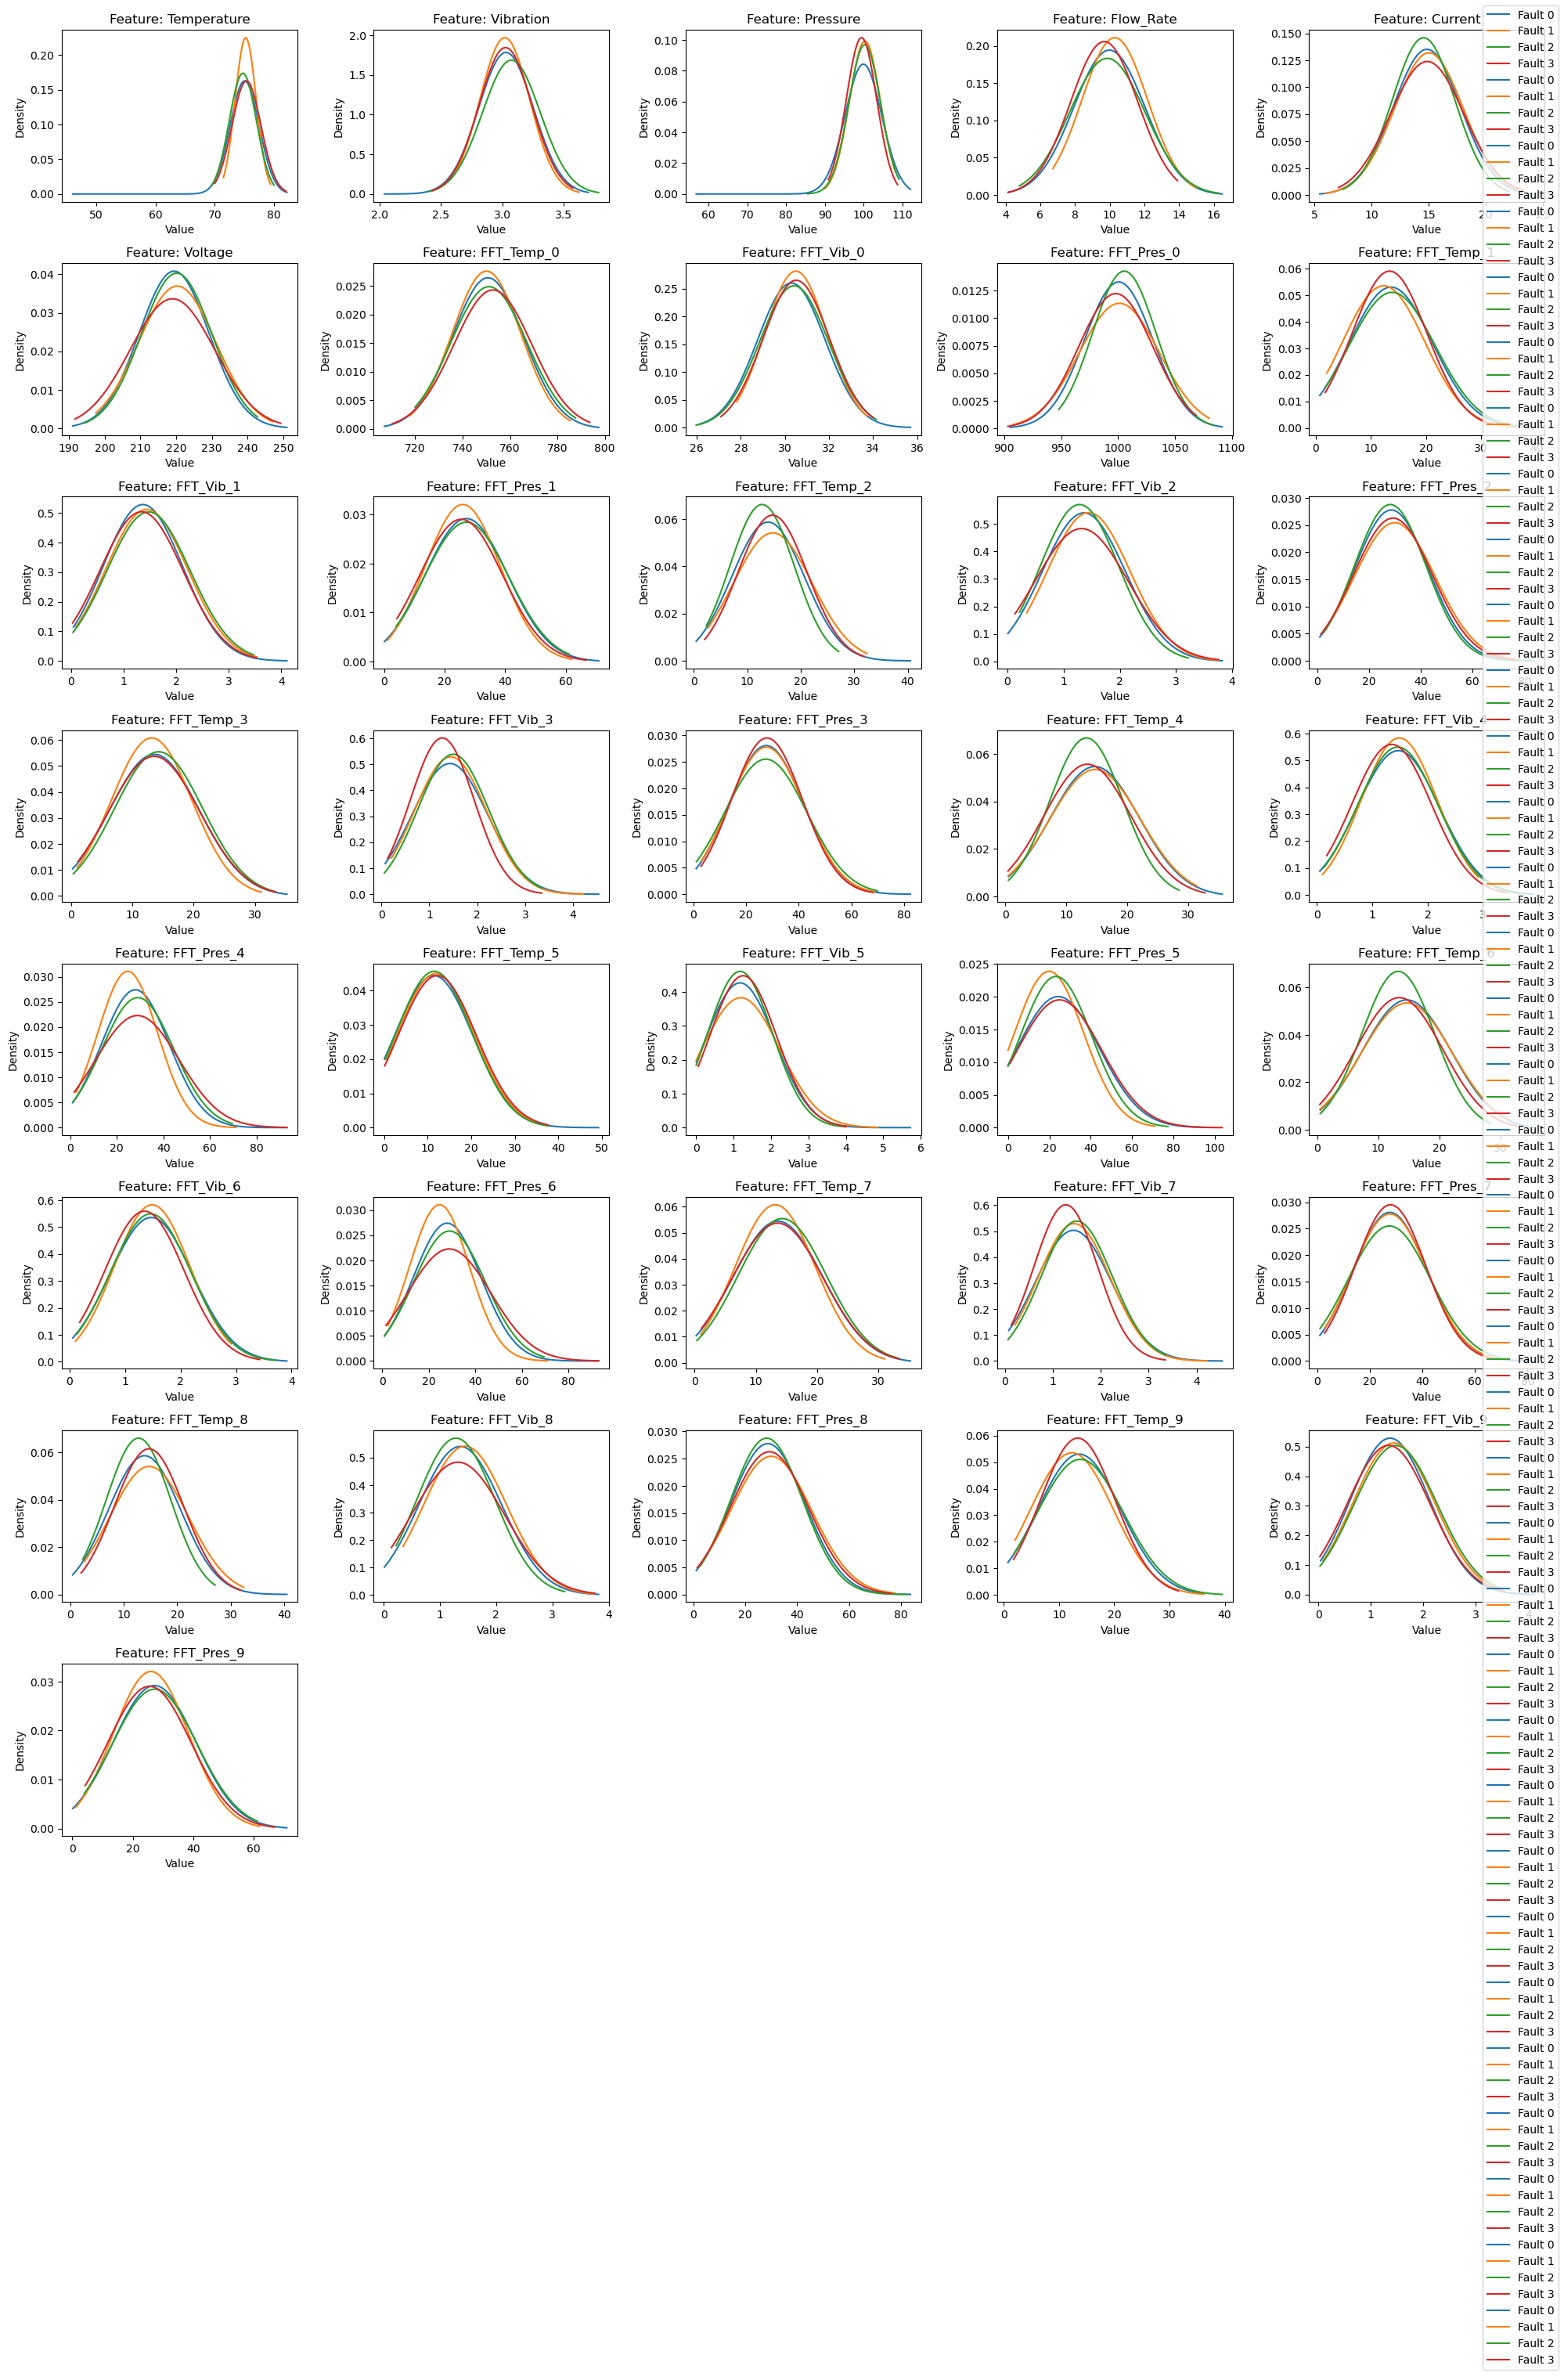

In [6]:
feature_names = X.columns
class_labels = np.unique(y)

num_features = len(feature_names)
num_classes = len(class_labels)

X_np = X.to_numpy()


n_cols = 5  # change to 2 or 4 if you prefer
n_rows = math.ceil(num_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=False)
axes = np.atleast_2d(axes).ravel()  # flatten to 1D for simple indexing

for feature_index in range(num_features):
    #plt.figure(figsize=(5, 5))
    ax = axes[feature_index]
    for class_label in class_labels:
        feature_values = X_np[y.values.ravel() == class_label, feature_index]
        mu = np.mean(feature_values)
        sigma = np.std(feature_values)
        xmin, xmax = feature_values.min(), feature_values.max()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, sigma) if sigma > 0 else np.zeros_like(x)
        ax.plot(x, p, label=f'Fault {class_label}')
    ax.set_title(f'Feature: {feature_names[feature_index]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    
    
# Hide any unused subplots
for j in range(num_features, len(axes)):
    axes[j].axis('off')
    
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [7]:
y_pred = gnb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy:           {acc:.4f}")
print(f"Balanced Accuracy:  {bal_acc:.4f}")
print(f"Macro F1:           {macro_f1:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))


Accuracy:           0.6061
Balanced Accuracy:  0.2224
Macro F1:           0.2023
Confusion Matrix:
 [[179   6  18   9]
 [ 30   0   1   1]
 [ 19   0   1   2]
 [ 30   1   0   0]]

Classification Report:
               precision    recall  f1-score   support

           0      0.694     0.844     0.762       212
           1      0.000     0.000     0.000        32
           2      0.050     0.045     0.048        22
           3      0.000     0.000     0.000        31

    accuracy                          0.606       297
   macro avg      0.186     0.222     0.202       297
weighted avg      0.499     0.606     0.547       297

